In [ ]:
#Import block
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math
from PIL import Image
import glob
import librosa
from random import sample
import librosa.display
import sklearn.metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import random

#Question 2: Implementing Linear SVMs
Given 15 images of the size (100, 100), we'd like to first perform high-dimentional PCA on this.

In [ ]:
# Load the data from the given link
train_data_path = "/content/drive/MyDrive/IISC/Second Semester/MLSP/Assignment_2/Data/emotion_classification/train/*.gif"
test_data_path = "/content/drive/MyDrive/IISC/Second Semester/MLSP/Assignment_2/Data/emotion_classification/test/*.gif"

#Import the data from the input locations
# plt.imshow(X_train[0])
X_train = np.zeros((20, 101, 101))
label_train = np.zeros((20, 1))
X_test = np.zeros((10, 101, 101))
label_test = np.zeros((10, 1))
count = 0
for filename in glob.glob(train_data_path): #assuming gif
    im=Image.open(filename)
    im = np.array(im)
    X_train[count] = im/255
    if 'happy' in filename:
      label_train[count] = 1
    else:
      label_train[count] = 0
    count += 1

count = 0
for filename in glob.glob(test_data_path): #assuming gif
    im=Image.open(filename)
    im = np.array(im)
    X_test[count] = im/255
    if 'happy' in filename:
      label_test[count] = 1
    else:
      label_test[count] = 0
    count += 1

In [ ]:
#Convert the dataset from a (N, 101, 101) dim to (N, 10201) dim
X_train_flattened = X_train.reshape(20, -1).T

In [ ]:
def constructDesignMatrix(X_train):
  X_train_mean = np.expand_dims(X_train.mean(axis=1), axis=1)
  designMatrix = (X_train - X_train_mean).T
  return designMatrix

def PCA(X_train, principalComponents = 10):
  #Data Processing
  X_train_mean = np.expand_dims(X_train.mean(axis=1), axis=1)
  designMatrix = (X_train - X_train_mean).T
  X_train_cov =  np.cov(designMatrix)

  # Find the Eigen Values from Eigen Decomposition
  eigenvalues, eigenvectors = np.linalg.eigh(X_train_cov)
  eigenvalues = eigenvalues[::-1]
  eigenvectors = eigenvectors[:, ::-1]
  transformationEV = eigenvalues[:principalComponents]
  transformationMatrix = eigenvectors[:, :principalComponents]

  # Find the actual Eigen Vectors
  originalTransformationMatrix = np.zeros((len(X_train),principalComponents))

  for i in range(principalComponents):
    originalTransformationMatrix[:,i] = (designMatrix.T @ transformationMatrix[:,i])/math.sqrt((len(eigenvalues) * eigenvalues[i]))

  # Project Data to Principal Components
  X_train_pca = originalTransformationMatrix.T @ designMatrix.T

  #Reconstruc the Image from projected Data
  X_train_reconstructed = originalTransformationMatrix @ X_train_pca + X_train_mean

  return X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean

In [ ]:
X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean = PCA(X_train_flattened, 18)

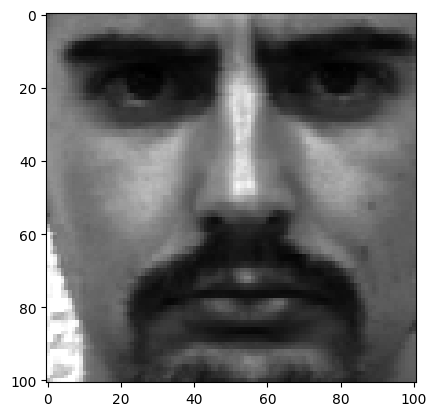

In [ ]:
plt.imshow(X_train_flattened.T[0].reshape(101, 101), cmap='gray')

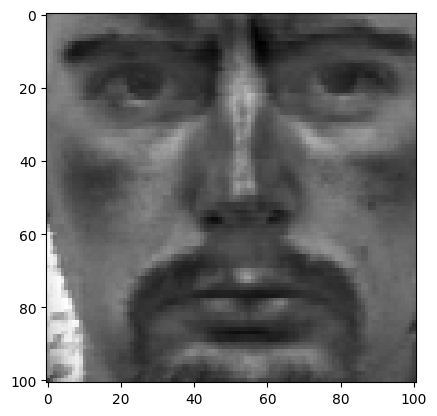

In [ ]:
plt.imshow(X_train_reconstructed.T[0].reshape(101, 101), cmap='gray')

Using scikit-learn, we'd like to train a linear classifier.

In [ ]:
#Implement a classifier on the training images with linear kernel based support vector machine using scikit-learn

from sklearn import svm
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train_pca.T, label_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

## Question 2.a
Test the test images using the trained SVM classifier and try different values of the kernels, parameter C and ϵ to observe the change in performance.

In [ ]:
# Given the test data, predict the values for this
def predict(X_test, originalTransformationMatrix):
  # Perform PCA on the test dataset
  designMatrixTest = constructDesignMatrix(X_test.reshape(10, -1).T)
  X_test_pca = originalTransformationMatrix.T @ designMatrixTest.T

  #Perform predictions on the test image
  predictions = svm_classifier.predict(X_test_pca.T)
  predictions = np.expand_dims(predictions, axis=1)

  return predictions

# Given the prediction and the true label, compute the accuacy
def findAccuracy(prediction, trueLabel):
  correct = 0
  for i in range(len(prediction)):
    if prediction[i] == trueLabel[i]:
      correct += 1
  return correct/len(prediction)

In [ ]:
pred = predict(X_test, originalTransformationMatrix)

In [ ]:
accuracy = findAccuracy(pred, label_test)
print(f"Accuracy on the SVM classifier on the test set is {accuracy}")

Accuracy on the SVM classifier on the test set is 0.9


Now, we'd like to test the SVM classifier for different values for various choices of kernel, and parameters C and ϵ

In [ ]:
#Make a list of the kernels to try SVM on {'poly'}
list_kernel = ['linear','rbf', 'sigmoid']
#Make a list of the C values to try the SVM on
list_C = C_values = [0.1, 1, 10, 100]
#Mkae a list of tolerance to try SVM on
list_tolerance = [1e-2, 1e-3, 1e-4]
#Make a list of different PCA values
list_pca = [6, 12, 18]

In [ ]:
dict_accuracy = {}
for kernel in list_kernel:
  for C in list_C:
    for tol in list_tolerance:
      for pca in list_pca:
        X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean = PCA(X_train_flattened, pca)
        svm_classifier = svm.SVC(kernel=kernel, C=C, tol=tol)
        svm_classifier.fit(X_train_pca.T, label_train.ravel())
        pred = predict(X_test, originalTransformationMatrix)
        accuracy = findAccuracy(pred.ravel(), label_test.ravel())
        dict_accuracy[(kernel, C, tol, pca)] = accuracy
        print(f"Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : {kernel, C, tol, pca} is {accuracy}")



Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.01, 6) is 0.5
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.01, 12) is 0.9
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.01, 18) is 0.9
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.001, 6) is 0.5
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.001, 12) is 0.9
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.001, 18) is 0.9
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PCA dim) : ('linear', 0.1, 0.0001, 6) is 0.5
Accuracy on the SVM classifier on the test set with parameters (Kernel, C, tolerance, PC

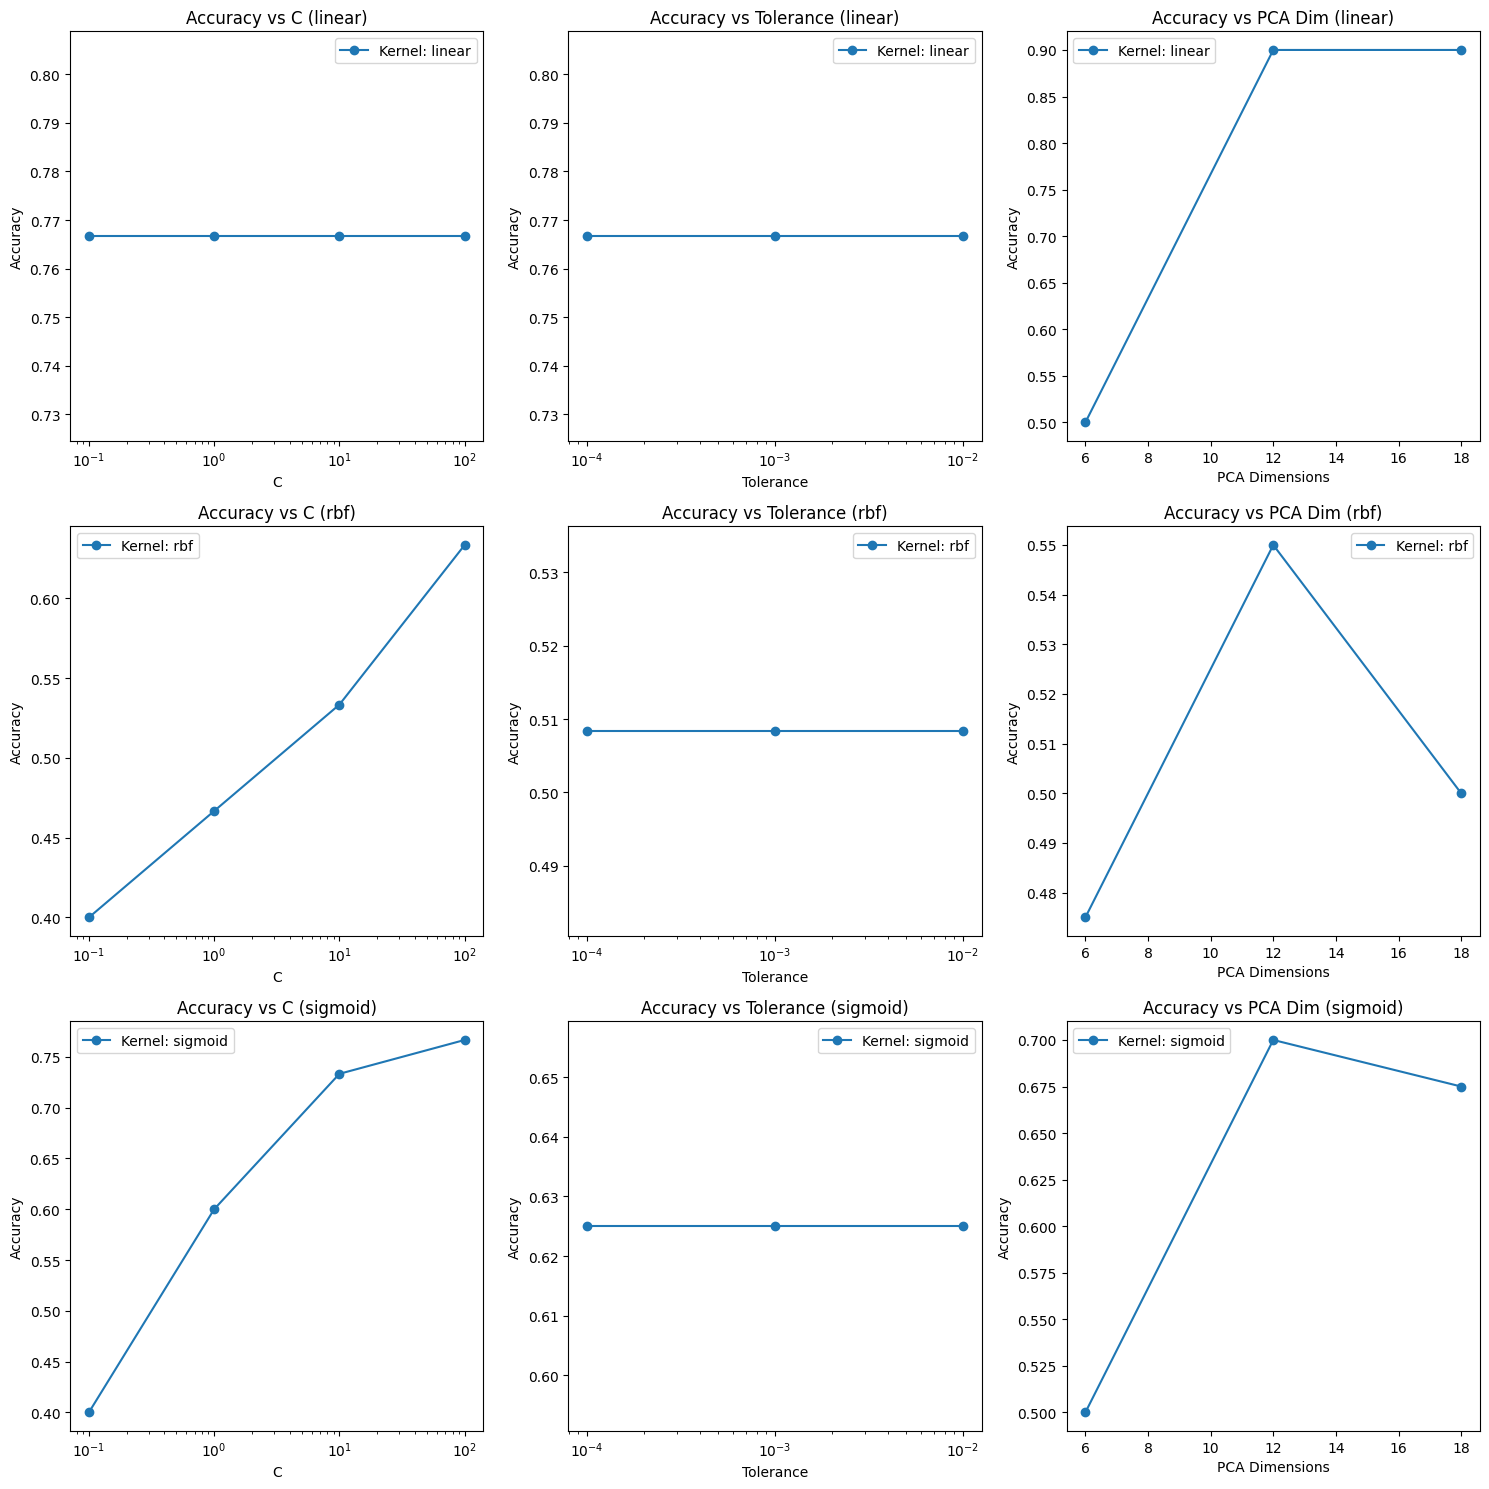

In [ ]:

fig, axes = plt.subplots(len(list_kernel), 3, figsize=(15, 5 * len(list_kernel)))  # 3 subplots for each kernel
axes = np.atleast_2d(axes)  # Ensure axes work properly for 1-row cases

for row, kernel in enumerate(list_kernel):
    acc_C = []
    acc_tol = []
    acc_pca = []

    for C in list_C:
        acc_C.append(np.mean([dict_accuracy[(kernel, C, tol, pca)] for tol in list_tolerance for pca in list_pca]))

    for tol in list_tolerance:
        acc_tol.append(np.mean([dict_accuracy[(kernel, C, tol, pca)] for C in list_C for pca in list_pca]))

    for pca in list_pca:
        acc_pca.append(np.mean([dict_accuracy[(kernel, C, tol, pca)] for C in list_C for tol in list_tolerance]))

    # Plot for C
    axes[row, 0].plot(list_C, acc_C, marker='o', linestyle='-', label=f'Kernel: {kernel}')
    axes[row, 0].set_xlabel('C')
    axes[row, 0].set_ylabel('Accuracy')
    axes[row, 0].set_xscale('log')  # Log scale for better visualization
    axes[row, 0].set_title(f'Accuracy vs C ({kernel})')
    axes[row, 0].legend()

    # Plot for tolerance
    axes[row, 1].plot(list_tolerance, acc_tol, marker='o', linestyle='-', label=f'Kernel: {kernel}')
    axes[row, 1].set_xlabel('Tolerance')
    axes[row, 1].set_ylabel('Accuracy')
    axes[row, 1].set_xscale('log')
    axes[row, 1].set_title(f'Accuracy vs Tolerance ({kernel})')
    axes[row, 1].legend()

    # Plot for PCA dimensions
    axes[row, 2].plot(list_pca, acc_pca, marker='o', linestyle='-', label=f'Kernel: {kernel}')
    axes[row, 2].set_xlabel('PCA Dimensions')
    axes[row, 2].set_ylabel('Accuracy')
    axes[row, 2].set_title(f'Accuracy vs PCA Dim ({kernel})')
    axes[row, 2].legend()

plt.tight_layout()
plt.show()


The accuracy for the PCA dimentions peak for the range of 6 to 15 for all the kernels (linear, rbf and sigmoid), linear stays at the same accuracy, whereas the other two drop off. This shows that the best PCA Dimentions to in between the 6 to 15 range.

The accuracy for the tolerance remain the same for all the 3 values that I've tested irrespective of the kernel showing that the accuracy is independent of the tolerance

The accuracy with respect to the C increases linearly for the sigmoid and the rbf kernel but remains constant for the linear. Hence, we'd likly not change the constant C for linear kernel but we're better of with a higher C value for the rbf and the sigmoid kernels

## Question 2.b
Compare the SVM classifier with LDA classifier



### Implemention of the LDA

In [ ]:
#Segregate the data based on the labels
def segregateData(X_train_pca, label_train):
  X_trainHappy = np.zeros((len(X_train_pca),1))
  X_trainSad = np.zeros((len(X_train_pca),1))
  countHappy = 0
  countSad = 0
  for i in range(len(X_train_pca[0])):
    if label_train[i] == 1:
      X_trainHappy = np.append(X_trainHappy, np.expand_dims(X_train_pca[:,i], axis = 1), axis = 1)
      countHappy += 1
    else:
      X_trainSad =np.append(X_trainSad, np.expand_dims(X_train_pca[:,i], axis = 1), axis = 1)
      countSad += 1

  X_trainHappy = X_trainHappy[:,1:]
  X_trainSad = X_trainSad[:,1:]
  return X_trainHappy, X_trainSad, countHappy, countSad

#Generate the within-Class Covariance Matrix
def generateWithinClassCV(X_trainHappy, X_trainSad, countHappy, countSad, X_trainHappyMean, X_trainSadMean):
  dimentions = len(X_trainHappy)
  X_trainHappySum = np.zeros((dimentions, dimentions))
  X_trainSadSum = np.zeros((dimentions, dimentions))

  for i in range(countHappy):
    diff = np.expand_dims(X_trainHappy[:,i], axis = 1) - X_trainHappyMean
    X_trainHappySum += np.outer(diff, diff)

  for i in range(countSad):
    diff = np.expand_dims(X_trainSad[:,i], axis = 1) - X_trainSadMean
    X_trainSadSum += np.outer(diff, diff)

  withinClassCV = (X_trainHappySum / (countHappy - 1) + X_trainSadSum / (countSad - 1))
  return withinClassCV

#Between Class Variance
def generateBetweenClassCV(diff):
  return np.outer(diff, diff)

#Generate the class mean difference
def generateClassMeanDiff(X_trainHappy, X_trainSad):
  X_trainHappyMean = X_trainHappy.mean(axis = 1, keepdims=True)
  X_trainSadMean = X_trainSad.mean(axis = 1, keepdims=True)
  diff = X_trainHappyMean - X_trainSadMean
  return X_trainHappyMean, X_trainSadMean, diff

  # Constructing the LDA Direction
def constructLDA(withinClassCV, diff):
  withinClassInv = np.linalg.inv(withinClassCV)
  ldaDirection = withinClassInv @ diff
  ldaDirectionNormalised = ldaDirection / np.linalg.norm(ldaDirection)
  return ldaDirectionNormalised

#Project the class data to LDA direction

def projectToLDA(ldaDirectionNormalised, X_trainHappy, X_trainSad):
  happy_lda_values = ldaDirectionNormalised.T @ X_trainHappy
  sad_lda_values = ldaDirectionNormalised.T @ X_trainSad
  return happy_lda_values, sad_lda_values

#Plot the LDA Labels
def plotLDA(happy_lda_values, sad_lda_values):
  plt.figure(figsize=(10, 6))
  plt.scatter(happy_lda_values, [0] * len(happy_lda_values[0]), color='blue', label='Happy')
  plt.scatter(sad_lda_values, [0] * len(sad_lda_values[0]), color='red', label='Sad')
  plt.xlabel("1D LDA Feature")
  plt.yticks([])  # Remove Y-axis ticks since it's 1D
  plt.axvline(x=0, color='gray', linestyle='--', alpha=0.9)
  plt.legend()
  plt.title("LDA Projection of Images to 1D Space")
  plt.show()

In [ ]:
def LDA(X_train_pca, label_train):
  X_trainHappy, X_trainSad, countHappy, countSad = segregateData(X_train_pca, label_train)
  X_trainHappyMean, X_trainSadMean, diff = generateClassMeanDiff(X_trainHappy, X_trainSad)
  withinClassCV = generateWithinClassCV(X_trainHappy, X_trainSad, countHappy, countSad, X_trainHappyMean, X_trainSadMean)
  betweenClassVariance = generateBetweenClassCV(diff)
  ldaDirectionNormalised = constructLDA(withinClassCV, diff)
  fisher_criterion = (ldaDirectionNormalised.T @ betweenClassVariance @ ldaDirectionNormalised)/(ldaDirectionNormalised.T @ withinClassCV @ ldaDirectionNormalised)

  happy_lda_values, sad_lda_values = projectToLDA(ldaDirectionNormalised, X_trainHappy, X_trainSad)

  return ldaDirectionNormalised, happy_lda_values, sad_lda_values, fisher_criterion

### Training the Model

In [ ]:
#Function to get the LDA model
def PCA_LDA(X_train, label_train, principalComponents = 10):
  X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean = PCA(X_train, principalComponents)
  ldaDirectionNormalised, happy_lda_values, sad_lda_values, fisher_criterion= LDA(X_train_pca, label_train)
  return originalTransformationMatrix, ldaDirectionNormalised, happy_lda_values, sad_lda_values, fisher_criterion

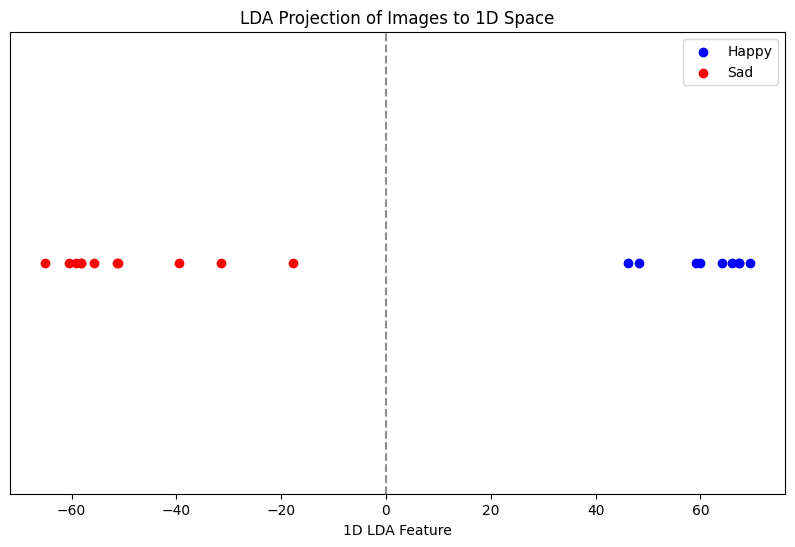

In [ ]:
#Get the Model
originalTransformationMatrix, ldaDirectionNormalised, happy_lda_values, sad_lda_values,fisher_criterion = PCA_LDA(X_train_flattened, label_train, 18)

### Testing the accuracy of LDA

In [ ]:
def predict_LDA(test_lda_values):
  prediction = []
  for i in range(len(test_lda_values[0])):
    if test_lda_values[0][i] > 0:
      prediction.append(1)
    else:
      prediction.append(0)

  return prediction

def findAccuracy_LDA(prediction, trueLabel):
  correct = 0
  for i in range(len(prediction)):
    if prediction[i] == trueLabel[i]:
      correct += 1
  return correct/len(prediction)

def testData_LDA(X_test, label_test, originalTransformationMatrix, ldaDirectionNormalised):
  designMatrixTest = constructDesignMatrix(X_test.reshape(10, -1).T)
  X_test_pca = originalTransformationMatrix.T @ designMatrixTest.T
  test_lda_values = ldaDirectionNormalised.T @ X_test_pca
  prediction = predict_LDA(test_lda_values)
  trueLabel = label_test[:,0].tolist()
  accuracy = findAccuracy_LDA(prediction, trueLabel)
  return prediction,accuracy, test_lda_values


In [ ]:
X_test_flattened = X_test.reshape(10, -1).T

In [ ]:
prediction, accuracy, test_lda_values = testData_LDA(X_test, label_test, originalTransformationMatrix, ldaDirectionNormalised)
print(f"The accurancy of the PCA + LDA is {accuracy * 100}")

The accurancy of the PCA + LDA is 90.0


### Comparison between SVM and LDA
Compare the test accuracies for SVM and LDA for different values of principal components

In [ ]:
# Different values of principal components for SVM and PCA
pca_values = [j for j in range(2, 18)]
svm_accuracies = []
lda_accuracies = []
for pca_value in pca_values:
  X_train_reconstructed, X_train_pca, originalTransformationMatrix_pca, X_train_mean = PCA(X_train_flattened, pca_value)
  originalTransformationMatrix_lda, ldaDirectionNormalised, happy_lda_values, sad_lda_values,fisher_criterion = PCA_LDA(X_train_flattened, label_train, pca_value)

  #Initialize SVM classifier
  svm_classifier = svm.SVC(kernel='linear')
  svm_classifier.fit(X_train_pca.T, label_train.ravel())

  #Find the accuracy of the test data for SVM
  pred = predict(X_test, originalTransformationMatrix_pca)
  accuracy_svm = findAccuracy(pred.ravel(), label_test.ravel())
  svm_accuracies.append(accuracy_svm)

  #Find the accuracy of the test data for LDA
  prediction, accuracy_lda, test_lda_values = testData_LDA(X_test, label_test, originalTransformationMatrix_lda, ldaDirectionNormalised)
  lda_accuracies.append(accuracy_lda)

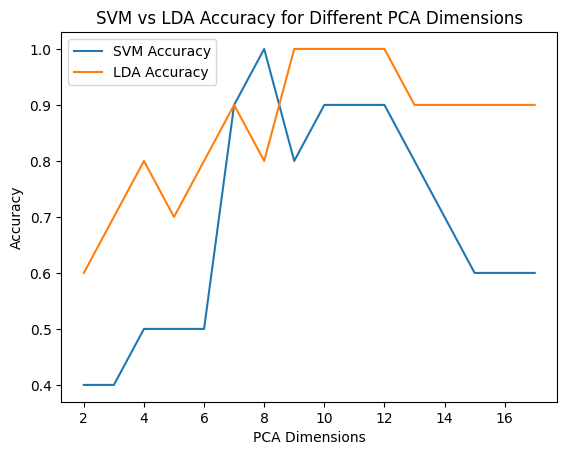

In [ ]:
#Plot the accuracies for SVM and LDA for different values of PCA Dimentions
plt.plot(pca_values, svm_accuracies, label='SVM Accuracy')
plt.plot(pca_values, lda_accuracies, label='LDA Accuracy')
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy')
plt.title('SVM vs LDA Accuracy for Different PCA Dimensions')
plt.legend()
plt.show()

#### Comment on the similarity and differences in terms of the problem formulation as well as the performance.

Both methods differ in their problem formulation. To compare them, assume both operate directly on the input space rather than the feature space
ϕ, meaning the SVM uses a linear kernel. LDA determines projection vectors that maximize class separation by leveraging within-class and between-class covariances, whereas SVM identifies a hyperplane that maximizes the margin. Despite their differences, both aim to find a hyperplane that optimizes separation, albeit using different definitions of separation.

Since LDA estimates covariance from the data, it is more sensitive to outliers, whereas SVM is more robust. To illustrate this, I created a small dataset and applied both SVM and LDA.

As far as the performance is concerned, I didn't notice any particular difference in the performance, with both of them giving same accuracies with tested with PCA dimentions of 18(90\%\), but for a range of PCA dimentions, we can notice that the accuracies for both of them peak at 6 to 15 PCA Dimentions then the SVM stays at that range whereas LDA drops

# Question 3: Supervised Sentiment Analysis


## 3.a Split the dataset randomly in (900, 100) subsets


In [ ]:
movieReview_inputPath = "/content/drive/MyDrive/IISC/Second Semester/MLSP/Assignment_2/movieReviews1000.txt"
#Load the text input file
with open(movieReview_inputPath, 'r') as f:
  movieReviews = f.readlines()
  f.close()

#Shuffle the dataset
np.random.shuffle(movieReviews)

#Strip the data into text and labels
movieReviews = [review.strip() for review in movieReviews]
movieReviews = [review.split('\t') for review in movieReviews]
movieReviews = np.array(movieReviews)
movieReviews_data = movieReviews[:, 0]
movieReviews_labels = movieReviews[:, 1]

In [ ]:
#Split the data to train and test
train_size = int(0.9*len(movieReviews_data))
test_size = len(movieReviews_data) - train_size
movieReviews_train_data = movieReviews_data[:train_size]
movieReviews_train_labels = movieReviews_labels[:train_size]
movieReviews_test_data = movieReviews_data[train_size:]
movieReviews_test_labels = movieReviews_labels[train_size:]

## 3.b: Feature extraction and PCA training in 30 dimentions

In [ ]:
#Given the training dataset consisting of the moview reviews, perform features extraction using Scikit-learn(TF-IDF)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(movieReviews_train_data)
movieReviews_train_data = X_train.toarray().T

In [ ]:
#The training set now of the dim (900, 2899), Now we perform the PCA on this dataset with 30 featuers
movieReviews_reconstructed, movieReviews_train_data_pca, movieReview_originalTransformationMatrix, movieReviews_train_data_mean = PCA(movieReviews_train_data, 30)

## 3.c Train a logistic regression model

In [ ]:
#Split the training dataset into train and validation
movieReview_train = movieReviews_train_data_pca[:, :810]
movieReview_train_labels = movieReviews_train_labels[:810]
movieReview_validation = movieReviews_train_data_pca[:, 810:]
movieReview_validation_labels = movieReviews_train_labels[810:]

In [ ]:
# Now, write a generator that yields (random) mini-batches of the input data
# Do not use same set of mini-batches for different epochs
# training_x is of dim(30, N) and training_y is of dim(N)
def get_minibatch(training_x, training_y, batch_size=32):
    indices = np.random.permutation(training_x.shape[1])  # Shuffle indices
    num_samples = training_x.shape[1]

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_indices = indices[start:end]

        yield training_x[:, batch_indices], training_y[batch_indices]  # Direct slicing


In [ ]:
#Implement Logistic regression without Sci-kit learn with stocatic gradient descent
class LogisticRegression:
    def __init__(self, input_size = 30, output_size = 1, learning_rate=0.01, num_iterations=10, batch_size = 32, regularization = 0):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        sigma = np.sqrt(2/(input_size + output_size))
        self.weights = np.random.normal(0, sigma, size=(output_size, input_size))
        # self.weights = np.zeros((output_size, input_size))
        self.bias = np.random.randn(output_size, 1)
        self.batch_size = batch_size
        self.regularization = regularization

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    #Calculate the stocastic loss
    def loss_SGD(self, y_pred, y_true):
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    #Compute the logits the logits from the model
    # X would have the dimentions
    def forward(self, x):
        return self.sigmoid(self.weights @ x + self.bias)

    def predict(self, X):
        preds = np.array([self.forward(X[:, i]) for i in range(X.shape[1])])
        return (preds >= 0.5).astype(int).flatten()

    #Fit the model with stocastic gradient descent
    #X_train would have dimentions (30, N)
    def fit_SGD(self, X_train, y_train, X_val = None, y_val = None):
        avg_train_loss_list = []
        avg_val_loss_list = []
        for i in range(self.num_iterations):
          train_loss_iteration = []

          for j in range(len(X_train)):
            x = X_train[:, j].reshape(-1, 1)#Dim would be (30, 1)
            y_true = y_train[j]#y_true would be a (N, 1)
            y_pred = self.forward(x)#Also a scalar(N, 1)

            loss = self.loss_SGD(y_pred, y_true)#Scalar
            train_loss_iteration.append(loss.item())

            error = np.squeeze(y_pred - y_true)

            self.weights -= self.learning_rate * error * x.T
            self.bias -= self.learning_rate * error

          avg_train_loss = np.mean(train_loss_iteration)
          avg_train_loss_list.append(avg_train_loss)

          #Generate the validation loss if the validation data is given
          if(X_val is not None and y_val is not None):
            X_val_pred = self.forward(X_val)
            val_loss = self.loss_SGD(X_val_pred, y_val.astype(int))
            avg_val_loss_list.append(val_loss)
            print(f"Iteration: {i+1}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}")
          #print and return the training loss
          else:
            print(f"Iteration: {i+1}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}")

        return avg_train_loss_list, avg_val_loss_list

    #Compute loss for Batch Gradient Descent
    # Dim of both are (1, batch_size)
    def loss_BGD(self, y_pred, y_true):
        epsilon = 1e-8
        term_1 = y_true * np.log(y_pred + epsilon)
        term_2 = (1 - y_true) * np.log(1 - y_pred + epsilon)
        loss = -(term_1 + term_2)
        # loss = np.squeeze(loss)
        return np.mean(loss)

    #Fit the model with batch gradient descent
    # X_train would have the dim(30, N) and y_train would have dim (N, )
    def fit_BGD(self, X_train, y_train, X_val, y_val):
      avg_train_loss_list = []
      avg_val_loss_list = []
      for i in range(self.num_iterations):
        train_loss_iteration = []
        mini_batch = get_minibatch(X_train, y_train)
        for x, y in mini_batch:# X would have dim (30, batch_size) and y would have (batch_size, )
            y_pred = self.sigmoid(self.weights @ x + self.bias) # Size would be (1, batch_size)
            loss = self.loss_BGD(y_pred, y)
            train_loss_iteration.append(loss.item())

            error = y_pred - y # dim (1, batch_size)
            batch_size = x.shape[1]
            self.weights -= ((self.learning_rate/batch_size) * error @ x.T) + self.regularization *  self.weights
            self.bias -= (self.learning_rate/batch_size) * np.sum(error)
        avg_train_loss = np.mean(train_loss_iteration)
        avg_train_loss_list.append(avg_train_loss)

        #Generate the validation loss

        X_val_pred = self.sigmoid(self.weights @ X_val + self.bias)
        val_loss = self.loss_BGD(X_val_pred, y_val.astype(int))
        avg_val_loss_list.append(val_loss.item())
        # print(f"Iteration: {i+1}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}")

      return avg_train_loss_list, avg_val_loss_list



### Performing Logistic regression with SGD

In [ ]:
LogisticRegressionObj = LogisticRegression(learning_rate=5e-2, num_iterations=20)
loss_list = LogisticRegressionObj.fit_SGD(movieReview_train, movieReview_train_labels.astype(int), movieReview_validation, movieReview_validation_labels.astype(int))

Iteration: 1, Training Loss: 0.7139828105065372, Validation Loss: 0.7933000260030535
Iteration: 2, Training Loss: 0.6871855136023262, Validation Loss: 0.7651583150496019
Iteration: 3, Training Loss: 0.6697367137281887, Validation Loss: 0.7474602950501601
Iteration: 4, Training Loss: 0.6574936870629505, Validation Loss: 0.7361808571650097
Iteration: 5, Training Loss: 0.6480850865384774, Validation Loss: 0.7288562593242228
Iteration: 6, Training Loss: 0.6402342470004554, Validation Loss: 0.7240056714614778
Iteration: 7, Training Loss: 0.6332758643900928, Validation Loss: 0.7207358174170204
Iteration: 8, Training Loss: 0.6268673556818661, Validation Loss: 0.7184993878387224
Iteration: 9, Training Loss: 0.6208313269662324, Validation Loss: 0.7169539778247784
Iteration: 10, Training Loss: 0.6150737028015868, Validation Loss: 0.7158806420813191
Iteration: 11, Training Loss: 0.6095423046381345, Validation Loss: 0.7151364891696138
Iteration: 12, Training Loss: 0.6042061768625018, Validation Lo

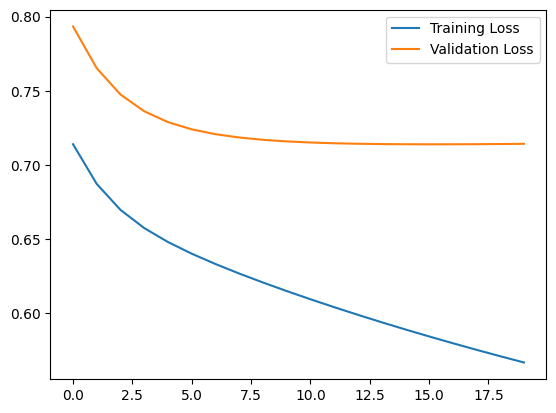

In [ ]:
plt.plot(loss_list[0], label='Training Loss')
plt.plot(loss_list[1], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy on the test dataset
movieReviews_test_data = movieReviews_data[train_size:]
movieReviews_test_labels = movieReviews_labels[train_size:]
X_test = vectorizer.transform(movieReviews_test_data)
movieReviews_test_data = X_test.toarray().T
movieReviews_test_data = movieReview_originalTransformationMatrix.T @ movieReviews_test_data
movieReviews_test_labels = movieReviews_test_labels.astype(int)

#Performing predictions
pred = LogisticRegressionObj.predict(movieReviews_test_data)
accuracy = findAccuracy(pred, movieReviews_test_labels)

print(f"Accuracy on the Logistic regression model with SGD on the test set is {accuracy}")

Accuracy on the Logistic regression model with SGD on the test set is 0.51


### Experimenting with batch sizes and learning rates
Perform Batch Gradient Descent with different hyper parameters

In [ ]:
# Making a list of different hyper-parameters
batch_sizes = [32,64,128]
learning_rates = [1e-3,1e-2,1e-1]

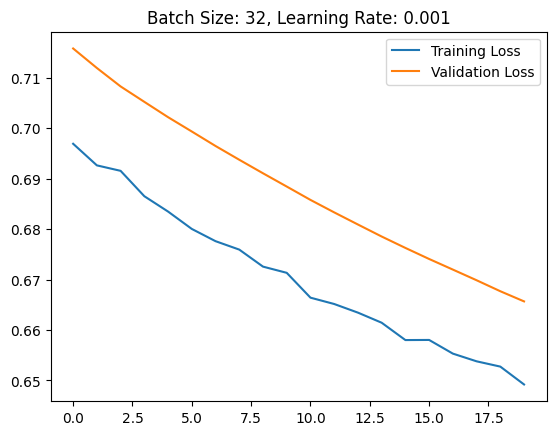

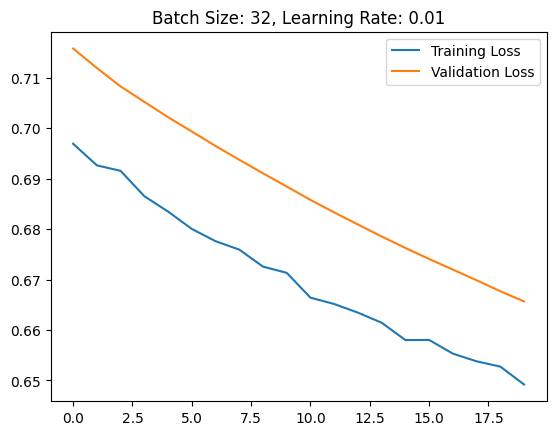

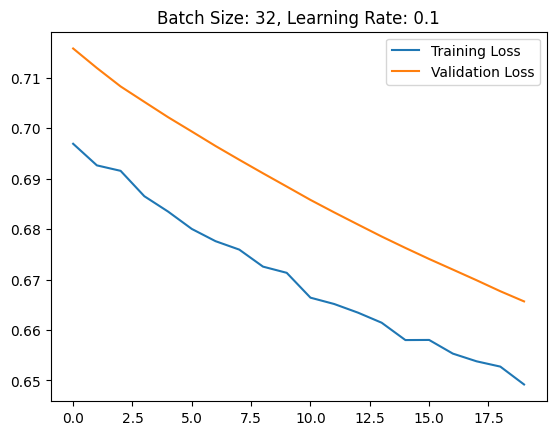

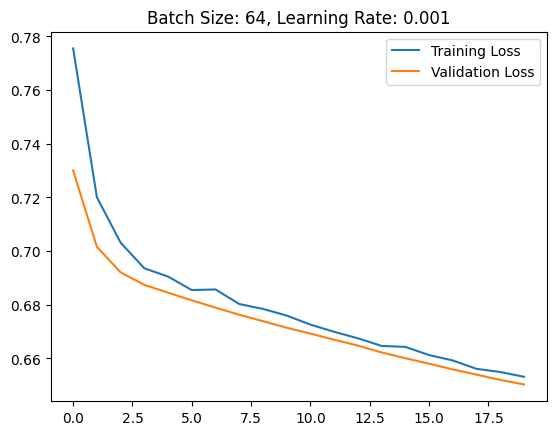

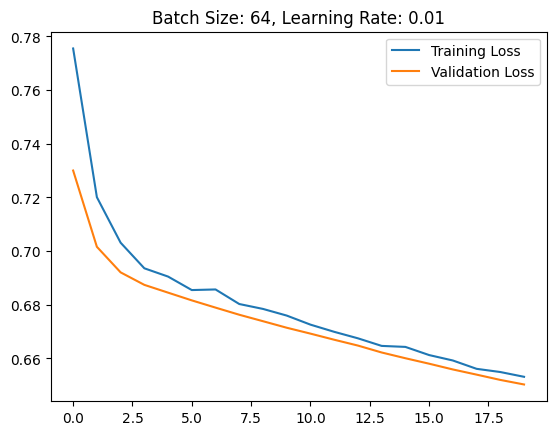

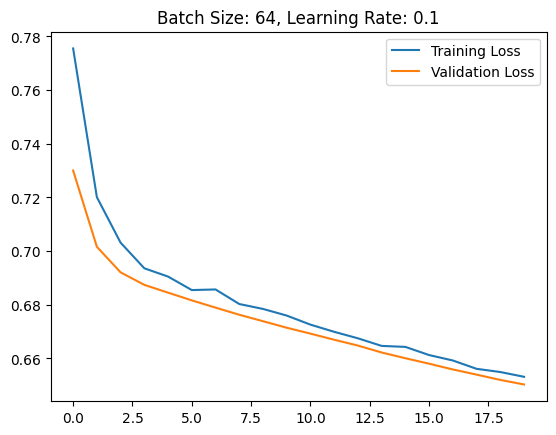

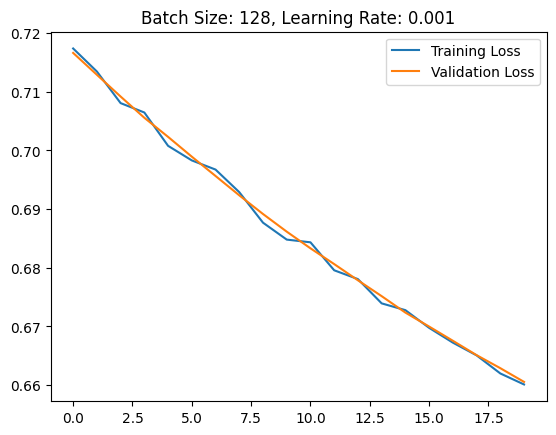

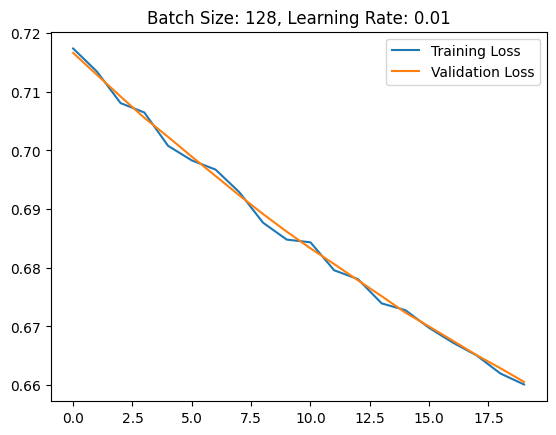

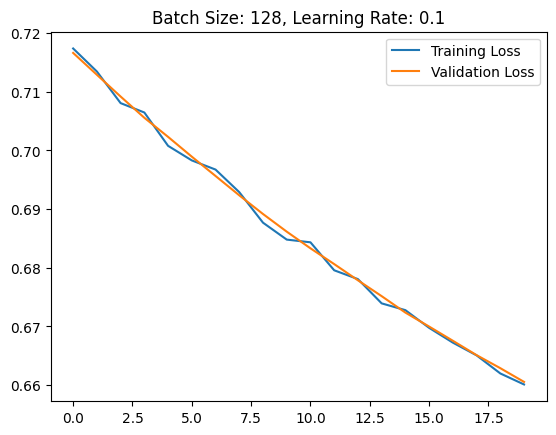

In [ ]:
training_losses = {}
validation_losses = {}
#Run the Logistic Regression model with Batch GD for different batch sizes and learning rate
for batch_size in batch_sizes:

  training_losses[batch_size] = {}
  validation_losses[batch_size] = {}

  for learning_rate in learning_rates:
    LogisticRegressionObj = LogisticRegression(learning_rate=learning_rate, num_iterations=20, batch_size=batch_size)
    loss_list = LogisticRegressionObj.fit_BGD(movieReview_train, movieReview_train_labels.astype(int), movieReview_validation, movieReview_validation_labels.astype(int))
    training_losses[batch_size]["learning_rate"] = loss_list[0]
    validation_losses[batch_size]["learning_rate"] = loss_list[1]
#Plot the training vs validation loss graphs for different batch sizes and learning rate
for batch_size in batch_sizes:
  for learning_rate in learning_rates:

    plt.plot(training_losses[batch_size]["learning_rate"], label='Training Loss')
    plt.plot(validation_losses[batch_size]["learning_rate"], label='Validation Loss')
    plt.title(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}")
    plt.legend()
    plt.show()



## 3.d Implement with logistic regression with L2 weight regularization
Experiment with different regularization values for L2 regularization

In [ ]:
#Different values of regularization terms
regularizations = [1e-2, 1e-1 , 1]

In [ ]:
regularization_train_losses = []
regularization_validation_losses = []
regularization_models = []
for regularization in regularizations:
  LogisticRegressionObj = LogisticRegression(learning_rate=5e-2, num_iterations=20, batch_size=movieReview_train.shape[1], regularization= regularization)
  loss_list = LogisticRegressionObj.fit_BGD(movieReview_train, movieReview_train_labels.astype(int), movieReview_validation, movieReview_validation_labels.astype(int))
  regularization_train_losses.append(loss_list[0])
  regularization_validation_losses.append(loss_list[1])
  regularization_models.append(LogisticRegressionObj)

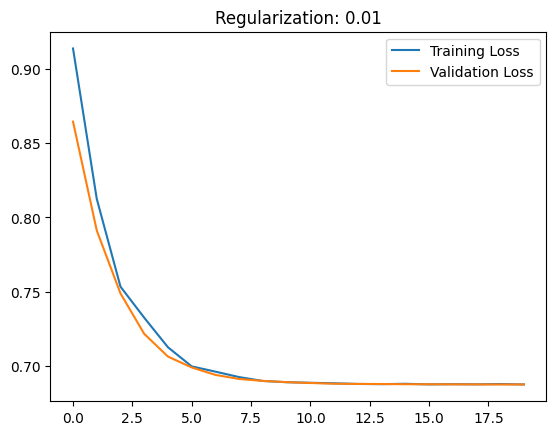

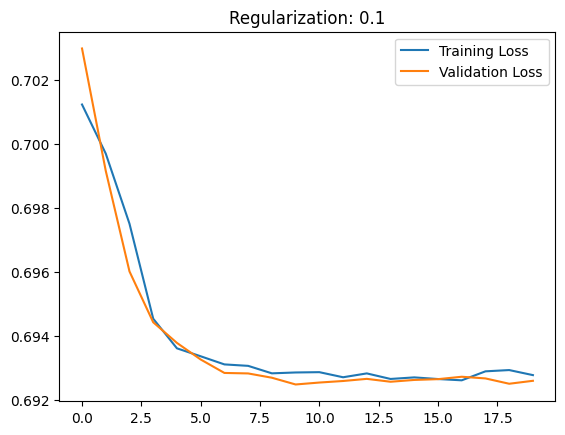

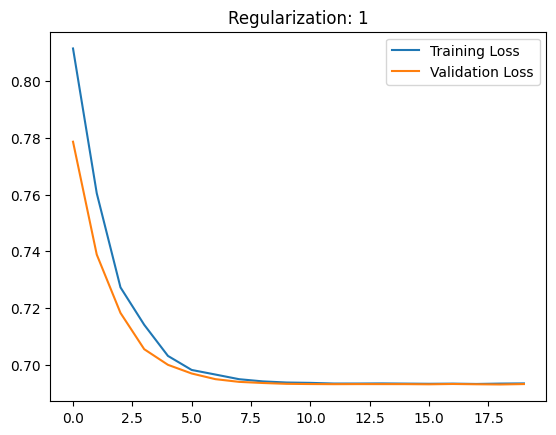

In [ ]:
#plot the training vs validation graphs for various regularization terms
for i in range(len(regularizations)):
  plt.plot(regularization_train_losses[i], label='Training Loss')
  plt.plot(regularization_validation_losses[i], label='Validation Loss')
  plt.title(f"Regularization: {regularizations[i]}")
  plt.legend()
  plt.show()

#### Test on the test data and report the performance on the test set in terms of review classification accuracy.

In [ ]:
# Checking the test accuracies on the models with different regularization
for i in range(len(regularization_models)):
  #Performing predictions
  LogisticRegressionObj = regularization_models[i]
  pred = LogisticRegressionObj.predict(movieReviews_test_data)
  accuracy = findAccuracy(pred, movieReviews_test_labels)

  print(f"Accuracy on the Logistic regression model with BGD and regularization of {regularizations[i]} on the test set is {accuracy}")

Accuracy on the Logistic regression model with BGD and regularization of 0.01 on the test set is 0.62
Accuracy on the Logistic regression model with BGD and regularization of 0.1 on the test set is 0.47
Accuracy on the Logistic regression model with BGD and regularization of 1 on the test set is 0.47


#### Do you see any overfitting/under-fitting for any of these choices.

As seen from the plots, the training and the validation curves are more or less the same and thus we can say for the 20 iterations that we've run the model. Upon checking the test accuracies of the test test for the different regularization terms, it can be seen that the model overfits on larger regularization terms. Though the above stated inferance could be wrong due to inavailiblity of larger test tests

# Question 6: Implementing BackPropagation
Given the subject faces with happy/sad emotion, with each image being 100 x100 matrix.

## 6.a Perform PCA
Perform PCA on the data to reduce the dimension
from 10000 to K = 12.

In [ ]:
# Load the data from the given link
train_data_path = "/content/drive/MyDrive/IISC/Second Semester/MLSP/Assignment_2/emotion_classification/train/*.gif"
test_data_path = "/content/drive/MyDrive/IISC/Second Semester/MLSP/Assignment_2/emotion_classification/test/*.gif"

#Import the data from the input locations
# plt.imshow(X_train[0])
X_train = np.zeros((20, 101, 101))
label_train = np.zeros((20, 1))
X_test = np.zeros((10, 101, 101))
label_test = np.zeros((10, 1))
count = 0
for filename in glob.glob(train_data_path): #assuming gif
    im=Image.open(filename)
    im = np.array(im)
    X_train[count] = im/255
    if 'happy' in filename:
      label_train[count] = 1
    else:
      label_train[count] = 0
    count += 1

count = 0
for filename in glob.glob(test_data_path): #assuming gif
    im=Image.open(filename)
    im = np.array(im)
    X_test[count] = im/255
    if 'happy' in filename:
      label_test[count] = 1
    else:
      label_test[count] = 0
    count += 1

In [ ]:
#Convert the dataset from a (N, 101, 101) dim to (N, 10201) dim
X_train_flattened = X_train.reshape(20, -1).T
label_train = np.array([np.array([1, 0]) if x == 1 else np.array([0, 1]) for x in label_train])
label_test = np.array([np.array([1, 0]) if x == 1 else np.array([0, 1]) for x in label_test])
# Perform PCA to reduce the dimmentions from 10000 to 12
X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean = PCA(X_train_flattened, 12)

## 6.b Train the model

In [ ]:

# Define the class for a Single Layer Classifier
class Single_layer_classifier():

    def __init__(self, input_size, hidden_size,  output_size, mean = 0, variance = 1e-3):

        ## WRITE CODE HERE

        # Give the instance a weight matrix, initialized randomly
        # One possible strategy for a good initialization is Normal (0, σ) where σ = 1e-3.
        # Try experimenting with different values of σ.
        sigma_1 = np.sqrt(2/(input_size + hidden_size))
        self.Weights_1 = np.random.normal(0, sigma_1, size=(hidden_size, input_size))
        sigma_2 = np.sqrt(2/(output_size + hidden_size))
        self.Weights_2 = np.random.normal(0, sigma_2, size=(output_size, hidden_size))
        self.relu = lambda x : np.maximum(0, x)


    # Define the forward function
    def forward(self, input_x):

        # get the scores

        ## WRITE CODE HERE
        scores = self.Weights_1 @ input_x
        self.linear_output_1 = scores
        scores = self.relu(scores)
        self.relu_output = scores
        scores = self.Weights_2 @ scores
        self.linear_output_2 = scores
        return scores

    # Similarly a backward function
    # we define 2 backward functions (as Loss = L_data + L_reg, grad(Loss) = grad(L1) + grad(L2))

    def backward_Ldata(self, grad_from_loss, input_x):

        # this function returns a matrix of the same size as the weights,
        # where each element is the partial derivative of the loss w.r.t. the corresponding element of W

        ## WRITE CODE HERE
        grad_matrix = grad_from_loss @ input_x.T
        return grad_matrix

    # backward function for the relu function
    def backward_L_relu(self, backward_Ldata, input_x):

        ## WRITE CODE HERE
        grad_matrix = backward_Ldata * (input_x > 0)
        return grad_matrix

In [ ]:
# Implement the Softmax loss function
def loss_function(input_y,scores):
    ## WRITE CODE HERE
    max_scores = np.max(scores, axis=0, keepdims=True)  # Prevent overflow
    logsumexp = np.log(np.sum(np.exp(scores - max_scores), axis=0)) + max_scores
    loss = (-np.trace(input_y @ scores) + np.sum(logsumexp)) / len(input_y)
    return loss

# Backward pass for the negative log loss
# Taking derivative with respect to logits from forward pass
def loss_backward(scores, input_y):
    # This part deals with the gradient of the loss w.r.t the output of network
    # for example, in case of softmax loss(-log(q_c)), this part gives grad(loss) w.r.t. q_c
    # pass this to backward_ldata

    ## WRITE CODE HERE
    grad_from_loss = np.zeros((len(scores)))
    for i in range(len(input_y)):
      max_score = np.max(scores[:, i])
      exp_scores = np.exp(scores[:, i] - max_score)
      softmax = exp_scores / np.sum(exp_scores)
      data  = -(input_y.T[:, i] - softmax)
      grad_from_loss = np.vstack((grad_from_loss, data))
    grad_from_loss = grad_from_loss[1:].T / len(input_y)
    return grad_from_loss


In [ ]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
# Train for t epochs:
###  Train on the train-set obtained from train-validation split
###  Use the mini-batch generator to get each mini-batch

print("Start of Model Train")
def train_model(x_train, y_train, number_of_epochs=100, learning_rate = 1e-4, hidden_layer = 10):
  slcObj = Single_layer_classifier(12, 10, 2)
  lossList = []
  accuracyList = []
  for i in range(number_of_epochs):
    ## Write code here for each iteration of training

    # Forward pass
    scores = slcObj.forward(x_train)
    loss = loss_function(y_train, scores)

    predicted_classes = np.argmax(scores, axis=0)
    true_classes = np.argmax(y_train, axis=1)
    accuracy = np.mean(predicted_classes == true_classes) * 100
    accuracyList.append(accuracy)

    # Backward pass

    #Backprop wrt to logits
    gradFromLoss = loss_backward(scores, y_train)
    #Backprop wrt to weights
    gradFromLinear2 = slcObj.backward_Ldata(gradFromLoss, slcObj.relu_output)
    gradFromLinear2_layer = slcObj.Weights_2.T @ gradFromLoss
    #backprop wrt to relu layer
    reluGradient = slcObj.backward_L_relu(gradFromLinear2_layer, slcObj.linear_output_1)
    #Backprop wrt linear layer 1
    gradFromLinear1 = slcObj.backward_Ldata(reluGradient, x_train)

    # Update weights
    slcObj.Weights_1 -= learning_rate * gradFromLinear1
    slcObj.Weights_2 -= learning_rate * gradFromLinear2

    # Log the training loss value and training accuracy
    lossList.append(loss)
    print(f"Iteration Number: {i} & loss: {loss} ")
  return slcObj, lossList, accuracyList

Start of Model Train


In [ ]:
slcObj, lossList, accuracyList = train_model(X_train_pca, label_train, 20, learning_rate=1e-3)

Iteration Number: 0 & loss: 69.83212601482526 
Iteration Number: 1 & loss: 58.95925125487743 
Iteration Number: 2 & loss: 49.61810458315466 
Iteration Number: 3 & loss: 41.32739938315813 
Iteration Number: 4 & loss: 33.98332104926261 
Iteration Number: 5 & loss: 27.84914116111464 
Iteration Number: 6 & loss: 24.296999850601303 
Iteration Number: 7 & loss: 21.846943635008653 
Iteration Number: 8 & loss: 19.433888761548253 
Iteration Number: 9 & loss: 17.291799776122865 
Iteration Number: 10 & loss: 15.228836869863978 
Iteration Number: 11 & loss: 14.328123438929605 
Iteration Number: 12 & loss: 13.30105832439428 
Iteration Number: 13 & loss: 10.88326436234595 
Iteration Number: 14 & loss: 9.709179245336179 
Iteration Number: 15 & loss: 10.086783914152733 
Iteration Number: 16 & loss: 7.594288854062114 
Iteration Number: 17 & loss: 6.474721670203974 
Iteration Number: 18 & loss: 5.857347986347497 
Iteration Number: 19 & loss: 4.543055258438159 


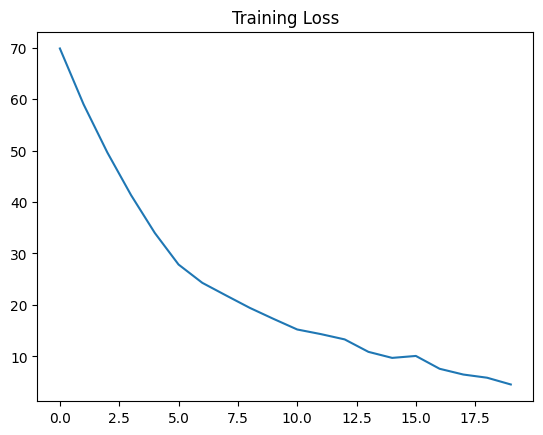

In [ ]:
#Plot the loss
plt.plot(lossList)
plt.title("Training Loss")
plt.show()


In [ ]:
def find_accuracy(slcObj, x, y):
  predictions = slcObj.forward(x)
  # print(predictions.shape)
  predicted_classes = np.argmax(predictions, axis=0)
  true_classes = np.argmax(y, axis=1)
  accuracy = np.mean(predicted_classes == true_classes) * 100
  return accuracy

In [ ]:
# Check the accuracy on the test dataset
X_test_flattened = X_test.reshape(10, -1).T
X_test_pca = originalTransformationMatrix.T @ X_test_flattened
test_accuracy = find_accuracy(slcObj, X_test_pca, label_test)
print(f"Accuracy on the test set is {test_accuracy}")

Accuracy on the test set is 70.0


## 6.c Check the test accuracy on different batch sizes


In [ ]:
#Different batch sizes
hidden_layer_sizes = [15,20,25,30]

In [ ]:
models = []
for size in hidden_layer_sizes:
  slcObj, lossList, accuracyList = train_model(X_train_pca, label_train, 20, 1e-3, hidden_layer = size)
  models.append(slcObj)

In [ ]:
for i in range(len(hidden_layer_sizes)):
  test_accuracy = find_accuracy(models[i], X_test_pca, label_test)
  print(f"Accuracy on the test set with hidden layer size {hidden_layer_sizes[i]} is {test_accuracy}")

Accuracy on the test set with hidden layer size 15 is 40.0
Accuracy on the test set with hidden layer size 20 is 90.0
Accuracy on the test set with hidden layer size 25 is 60.0
Accuracy on the test set with hidden layer size 30 is 50.0
